## Import Library

In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pemisahan Dataset dan Augmentasi Data



In [3]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

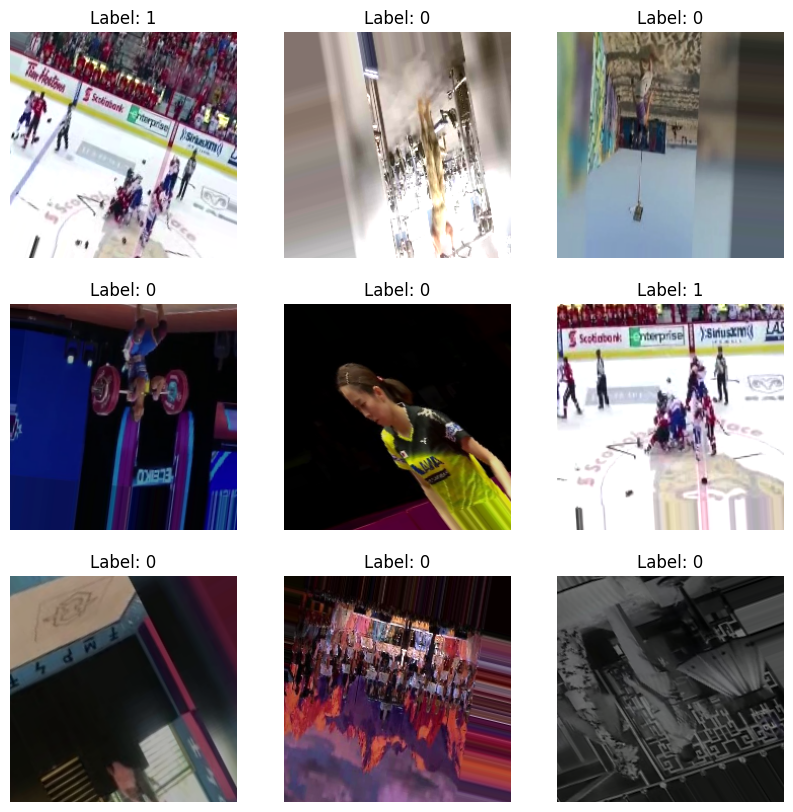

In [4]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [5]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:20]:
    layer.trainable = False
for layer in base_model.layers[20:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_Freeze20_0.01.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6652 - loss: 1.4082
Epoch 1: val_accuracy improved from -inf to 0.60455, saving model to NoMCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 605s 12s/step - accuracy: 0.6661 - loss: 1.4067 - val_accuracy: 0.6045 - val_loss: 1.4197
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.7697 - loss: 1.0666
Epoch 2: val_accuracy improved from 0.60455 to 0.62045, saving model to NoMCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 768ms/step - accuracy: 0.7697 - loss: 1.0658 - val_accuracy: 0.6205 - val_loss: 1.3742
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.7861 - loss: 0.9148
Epoch 3: val_accuracy improved from 0.62045 to 0.81136, saving model to NoMCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 791ms/step - accuracy: 0.7861 - loss: 0.9141 - val_accuracy: 0.8114 - val_loss: 0.7588
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7986 - loss: 0.8269
Epoch 4: val_accuracy did not improve from 0.81136
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 738ms/step - accuracy: 0.7984 - loss: 0.8272 - val_accuracy: 0.7568 - val_loss: 0.8194
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.8223 - loss: 0.7354
Epoch 5: val_accuracy did not improve from 0.81136
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 733ms/step - accuracy: 0.8221 - loss: 0.7355 - val_accuracy: 0.8114 - val_loss: 0.6723
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8021 - loss: 0.7162
Epoch 6: val_accuracy improved from 0.81136 to 0.84318, saving model to NoMCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 773ms/step - accuracy: 0.8021 - loss: 0.7163 - val_accuracy: 0.8432 - val_loss: 0.6083
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.8050 - loss: 0.6787
Epoch 7: val_accuracy improved from 0.84318 to 0.85455, saving model to NoMCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 746ms/step - accuracy: 0.8050 - loss: 0.6787 - val_accuracy: 0.8545 - val_loss: 0.5916
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.8199 - loss: 0.6266
Epoch 8: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 756ms/step - accuracy: 0.8197 - loss: 0.6270 - val_accuracy: 0.8477 - val_loss: 0.5678
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.8131 - loss: 0.6356
Epoch 9: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 774ms/step - accuracy: 0.8134 - loss: 0.6353 - val_accuracy: 0.8341 - val_loss: 0.6025
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8179 - loss: 0.6438
Epoch 10: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 792ms/step - accuracy: 0.8181 - loss: 0.6436 - val_accuracy: 0.7250 - val_loss: 0.8550
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8035 - loss: 0.7237
Epoch 11: val_accuracy did n

49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 740ms/step - accuracy: 0.8114 - loss: 0.7758 - val_accuracy: 0.8568 - val_loss: 0.6139
Epoch 45/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8209 - loss: 0.6885
Epoch 45: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 770ms/step - accuracy: 0.8206 - loss: 0.6888 - val_accuracy: 0.6341 - val_loss: 0.9438
Epoch 46/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8137 - loss: 0.6827
Epoch 46: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 746ms/step - accuracy: 0.8138 - loss: 0.6827 - val_accuracy: 0.7023 - val_loss: 1.0027
Epoch 47/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.8104 - loss: 0.6581
Epoch 47: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 787ms/step - accuracy: 0.8104 - loss: 0.6581 - val_accuracy: 0.8432 - val_loss: 0.6039
Epoch 48/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.8147 - loss: 0.6387
Epoch 48: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.7941 - loss: 0.7010
Validation Loss: 0.6666165590286255
Validation Accuracy: 0.824999988079071


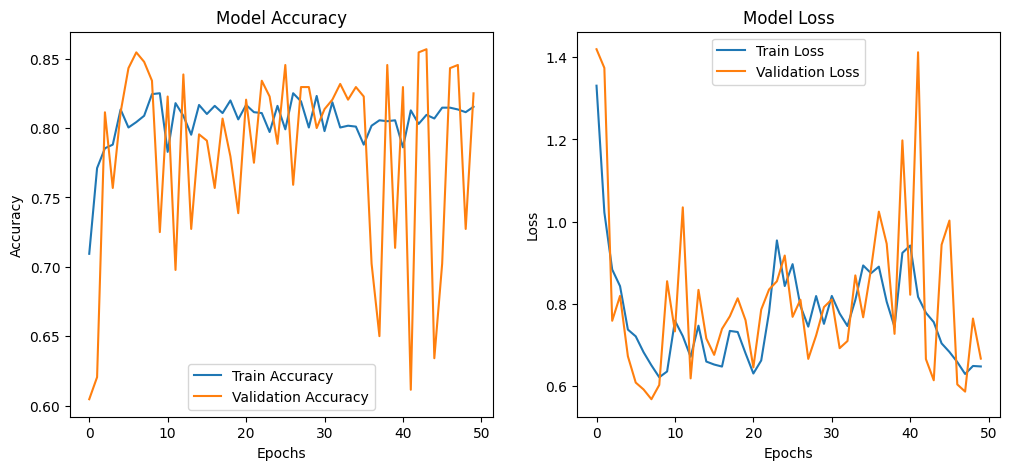

In [7]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [8]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_Freeze20_0.01.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 11s/step - accuracy: 0.8085 - loss: 0.6508
Test Accuracy : 84.68%
Test Loss     : 0.600


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step


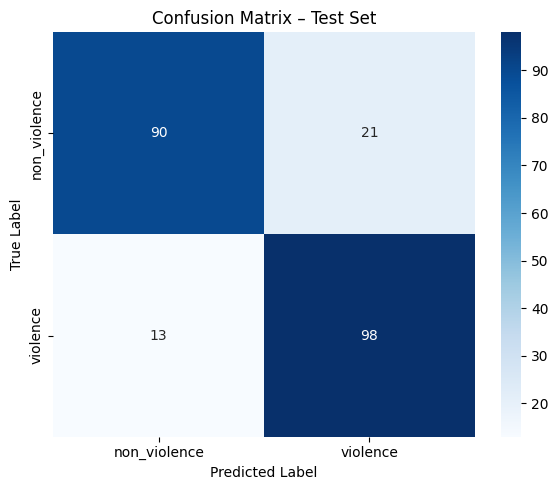


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.87      0.81      0.84       111
    violence       0.82      0.88      0.85       111

    accuracy                           0.85       222
   macro avg       0.85      0.85      0.85       222
weighted avg       0.85      0.85      0.85       222



In [9]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))